In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os
import numpy as np
import xarray as xr
import torch

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

sys.path.append('../../mre_ai')
#import mre_ai.mre_datasets

torch.cuda.is_available()

Using backend: pytorch



True

In [ ]:
nifti_dirs = [
    'MRE_DICOM_7-31-19',
    'MRE_DICOM_9-12-19',
    'MRE_DICOM_10-09-19',
    'MRE_DICOM_10-22-19'
]

sequences = [
    'dwi',
    'mre',
    'mre_mask',
    'mre_raw',
    'mre_wave',
    'mre_phase',
    #'t1_pos_0_fat',
    #'t1_pos_0_in',
    #'t1_pos_0_out',
    #'t1_pos_0_water',
    #'t1_pos_160_fat',
    #'t1_pos_160_in',
    #'t1_pos_160_out',
    #'t1_pos_160_water',
    #'t1_pos_300_fat',
    #'t1_pos_300_in',
    #'t1_pos_300_out',
    #'t1_pos_300_water',
    #'t1_pos_70_fat',
    #'t1_pos_70_in',
    #'t1_pos_70_out',
    #'t1_pos_70_water',
    #'t1_pre_fat',
    #'t1_pre_in',
    #'t1_pre_out',
    't1_pre_water',
    #'t2',
    'wave'
]

def load_nifti_metadata(nii_file):
    image = sitk.ReadImage(nii_file)
    dim = image.GetDimension()
    size = image.GetSize()
    origin = image.GetOrigin()
    spacing = image.GetSpacing()
    components = image.GetNumberOfComponentsPerPixel()
    type_ = image.GetPixelIDTypeAsString()
    return image, dim, size, origin, spacing, components, type_

import pandas as pd
index_cols = ['nifti_dir', 'patient_id', 'sequence']
df = pd.DataFrame(columns=index_cols).set_index(index_cols)

for nifti_dir in nifti_dirs[:1]:
    print(nifti_dir)
    nifti_dir = os.path.join(data_root, nifti_dir, 'NIFTI')
    patient_ids = sorted(os.listdir(nifti_dir))
    n_patient_ids = len(patient_ids)
    for i, patient_id in enumerate(patient_ids):
        print(f'  [{i+1} / {n_patient_ids}] {patient_id}')
        patient_dir = os.path.join(nifti_dir, patient_id)
        for nii_base in os.listdir(patient_dir):
            if not nii_base.endswith('.nii'):
                continue
            seq = os.path.splitext(nii_base)[0]
            idx = (nifti_dir, patient_id, seq)
            nii_file = os.path.join(nifti_dir, patient_id, nii_base)
            image = sitk.ReadImage(nii_file)
            df.loc[idx, 'dimension'] = image.GetDimension()
            df.loc[idx, 'size'] = str(image.GetSize())
            df.loc[idx, 'origin'] = str(image.GetOrigin())
            df.loc[idx, 'spacing'] = str(image.GetSpacing())
            df.loc[idx, 'components'] = image.GetNumberOfComponentsPerPixel()
            df.loc[idx, 'type'] = image.GetPixelIDTypeAsString()

df

In [ ]:
df.groupby('sequence').nunique()

In [ ]:
df.loc[:,:,['t1_pre_water','mre', 'wave']].groupby(['sequence', 'size']).count()

## Data processing steps

- load SITK images from NIFIT files
- perform filtering/inpainting on wave image
- register images wrt anatomical image
- load segmentation model
- perform image segmentation
- convert images to xarray Dataset

In [3]:
%pwd

'/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks'

In [12]:
%autoreload
patient = mre_pinn.data.Patient(
    nifti_dir='/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI',
    patient_id='0006',
    sequences=[
        't1_pre_in', 't1_pre_water', 't1_pre_out', 't1_pre_fat', 't2', 'mre_raw', 'wave', 'mre'
    ],
    xarray_dir='../data/NAFLD/'
)
patient.load_images()
patient.metadata

Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/mre.nii


size    spacing      origin       limit      center  \
sequence     dimension                                                        
t1_pre_in    0           512   0.703100 -204.130005  155.154108  -24.487948   
             1           512   0.703100 -208.591995  150.692118  -28.949939   
             2            88   2.300003 -142.013000   58.087265  -41.962868   
t1_pre_water 0           512   0.703100 -204.130005  155.154108  -24.487948   
             1           512   0.703100 -208.591995  150.692118  -28.949939   
             2            88   2.300003 -142.013000   58.087265  -41.962868   
t1_pre_out   0           512   0.703100 -204.130005  155.154108  -24.487948   
             1           512   0.703100 -208.591995  150.692118  -28.949939   
             2            88   2.300003 -142.013000   58.087265  -41.962868   
t1_pre_fat   0           512   0.703100 -204.130005  155.154108  -24.487948   
             1           512   0.703100 -208.591995  150.692118  -28.949939   
             2            88   2.300003 -142.013000   58.087265  -41.962868   
t2           0           256   1.406300 -200.263000  158.343486  -20.959757   
             1           256   1.406300 -208.240997  150.365490  -28.937754   
             2            23  10.000000 -154.516006   65.483994  -44.516006   
mre_raw      0           256   1.406300 -206.904007  151.702480  -27.600763   
             1           256   1.406300 -195.858994  162.747493  -16.555750   
             2             4   1.000000    0.000000    3.000000    1.500000   
wave         0           512   1.000000    0.000000  511.000000  255.500000   
             1           512   1.000000    0.000000  511.000000  255.500000   
             2             4   1.000000    0.000000    3.000000    1.500000   
mre          0           256   1.406300 -206.904007  151.702480  -27.600763   
             1           256   1.406300 -195.858994  162.747493  -16.555750   
             2             4  11.000000   -1.056400   31.943600   15.443600   

                            extent  
sequence     dimension              
t1_pre_in    0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_water 0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_out   0          359.987213  
             1          359.987213  
             2          202.400269  
t1_pre_fat   0          359.987213  
             1          359.987213  
             2          202.400269  
t2           0          360.012787  
             1          360.012787  
             2          230.000000  
mre_raw      0          360.012787  
             1          360.012787  
             2            4.000000  
wave         0          512.000000  
             1          512.000000  
             2            4.000000  
mre          0          360.012787  
             1          360.012787  
             2           44.000000

In [13]:
%autoreload
model = mre_pinn.data.patient.load_segment_model('cuda')
patient.preprocess_images(mask_seq='t2', model=model)

Loading segmentation model
Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Resizing t1_pre_in to (256, 256, 32)
Resizing t1_pre_water to (256, 256, 32)
Resizing t1_pre_out to (256, 256, 32)
Resizing t1_pre_fat to (256, 256, 32)
Resizing t2 to (256, 256, 32)
Resizing mre_raw to (256, 256, 32)
Resizing wave to (256, 256, 32)
Resizing mre to (256, 256, 32)
Segmenting t2
Registering t1_pre_in to mre_raw
Registering t1_pre_water to mre_raw
Registering t1_pre_out to mre_raw
Registering t1_pre_fat to mre_raw
Registering t2 to mre_raw
Transforming mask


In [14]:
patient.describe()

,dtype,count,mean,std,min,25%,50%,75%,max
sequence,,,,,,,,,
t1_pre_in,float32,2097152,280.630646,345.485687,-12.911273,29.715098,169.812119,422.542923,2966.341064
t1_pre_water,float32,2097152,145.480652,192.839294,-53.881084,15.567025,40.662952,256.408424,2229.621582
t1_pre_out,float32,2097152,231.083771,305.403259,-11.540190,28.729784,112.760777,324.326607,2797.954590
t1_pre_fat,float32,2097152,164.750412,366.890289,-51.799564,16.286475,30.231266,91.145744,3590.599854
t2,float32,2097152,83.197487,112.575325,-31.659052,0.289436,32.889793,126.039085,899.048462
mre_raw,int16,2097152,46.502714,59.247692,0.000000,1.000000,21.000000,76.000000,553.000000
wave,float64,2097152,0.001391,0.212059,-0.996094,-0.041992,0.000000,0.044922,0.996094
mre,int16,2097152,1505.607792,1282.418007,0.000000,0.000000,1387.000000,2185.000000,14078.000000
mask,float32,2097152,0.144877,0.351977,0.000000,0.000000,0.000000,0.000000,1.000000


Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray


<IPython.core.display.Javascript object>


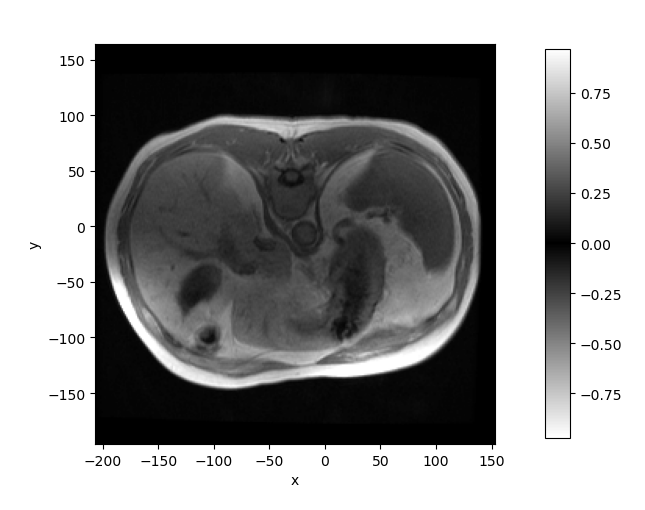

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [15]:
%autoreload
patient.view(compare=True)

In [19]:
%autoreload
patient.save_xarrays()

In [20]:
patient.load_xarrays()

<IPython.core.display.Javascript object>


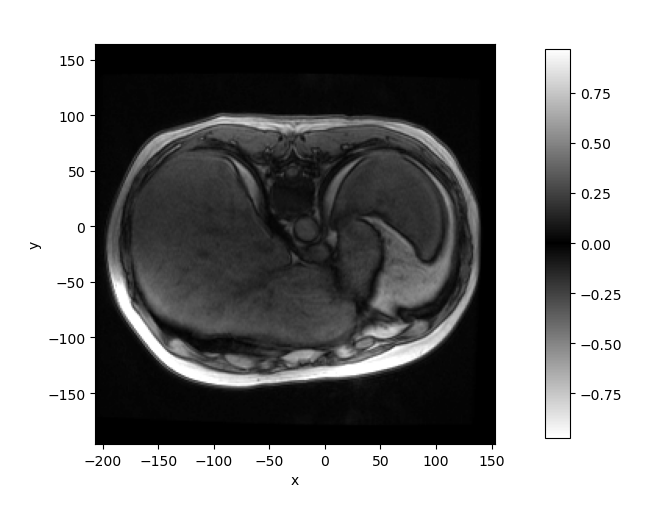

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [21]:
patient.view(compare=True)